In [1]:
#
# Forcast price from sales data 
# This notebook serves to explore the forecasting process for later implementation.
# 
# Author: George Hatem      Last Updated: 2022-10-06
#

In [2]:
import pandas as pd
import numpy as np

din = pd.read_csv("./Data/avocado.csv")
din.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
price = din.groupby("Date")[["AveragePrice"]].mean().reset_index()
price.head(10)

,Date,AveragePrice
0,2015-01-04,1.301296
1,2015-01-11,1.370648
2,2015-01-18,1.391111
3,2015-01-25,1.397130
4,2015-02-01,1.247037
5,2015-02-08,1.310463
6,2015-02-15,1.387593
7,2015-02-22,1.362685
8,2015-03-01,1.311019
9,2015-03-08,1.360093


In [4]:
volume = din.groupby("Date")[["Total Volume"]].sum().reset_index()
volume.head(10)

,Date,Total Volume
0,2015-01-04,8.467434e+07
1,2015-01-11,7.855581e+07
2,2015-01-18,7.838878e+07
3,2015-01-25,7.646628e+07
4,2015-02-01,1.194532e+08
5,2015-02-08,8.667111e+07
6,2015-02-15,7.563716e+07
7,2015-02-22,8.087609e+07
8,2015-03-01,8.943484e+07
9,2015-03-08,8.128167e+07


In [5]:
cleaned = price.join(volume.set_index("Date"), on="Date")
cleaned.head()

,Date,AveragePrice,Total Volume
0,2015-01-04,1.301296,8.467434e+07
1,2015-01-11,1.370648,7.855581e+07
2,2015-01-18,1.391111,7.838878e+07
3,2015-01-25,1.397130,7.646628e+07
4,2015-02-01,1.247037,1.194532e+08


In [6]:
from datetime import datetime

date = cleaned["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").toordinal())
cleaned.set_index(pd.to_datetime(cleaned["Date"]), inplace=True)
cleaned.drop(columns=["Date"], inplace=True)

In [7]:
cleaned.head()

,AveragePrice,Total Volume
Date,,
2015-01-04,1.301296,8.467434e+07
2015-01-11,1.370648,7.855581e+07
2015-01-18,1.391111,7.838878e+07
2015-01-25,1.397130,7.646628e+07
2015-02-01,1.247037,1.194532e+08


In [8]:
from sklearn.linear_model import LinearRegression
priceReg_trend = LinearRegression().fit(date.fillna(date.median()).values.reshape(-1, 1), cleaned["AveragePrice"])

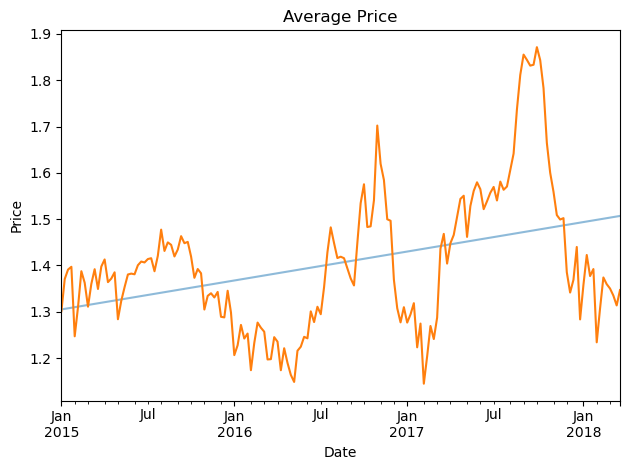

In [9]:
from matplotlib import pyplot as plt
p = pd.Series(priceReg_trend.predict(date.fillna(date.median()).values.reshape(-1, 1)), index=cleaned.index).plot(alpha=0.5, title="Average Price", ylabel="Price")
p = cleaned["AveragePrice"].plot()
p.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.show()

In [10]:
pr_detrended = cleaned["AveragePrice"] - priceReg_trend.predict(date.fillna(date.median()).values.reshape(-1, 1))

<AxesSubplot:xlabel='Date'>

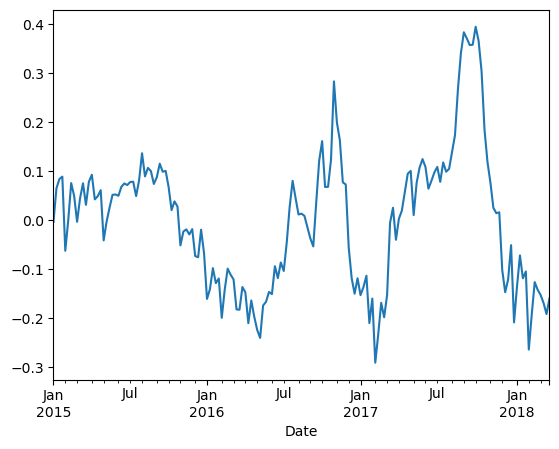

In [11]:
pr_detrended.plot()

Text(0.5, 1.0, 'Periodogram')

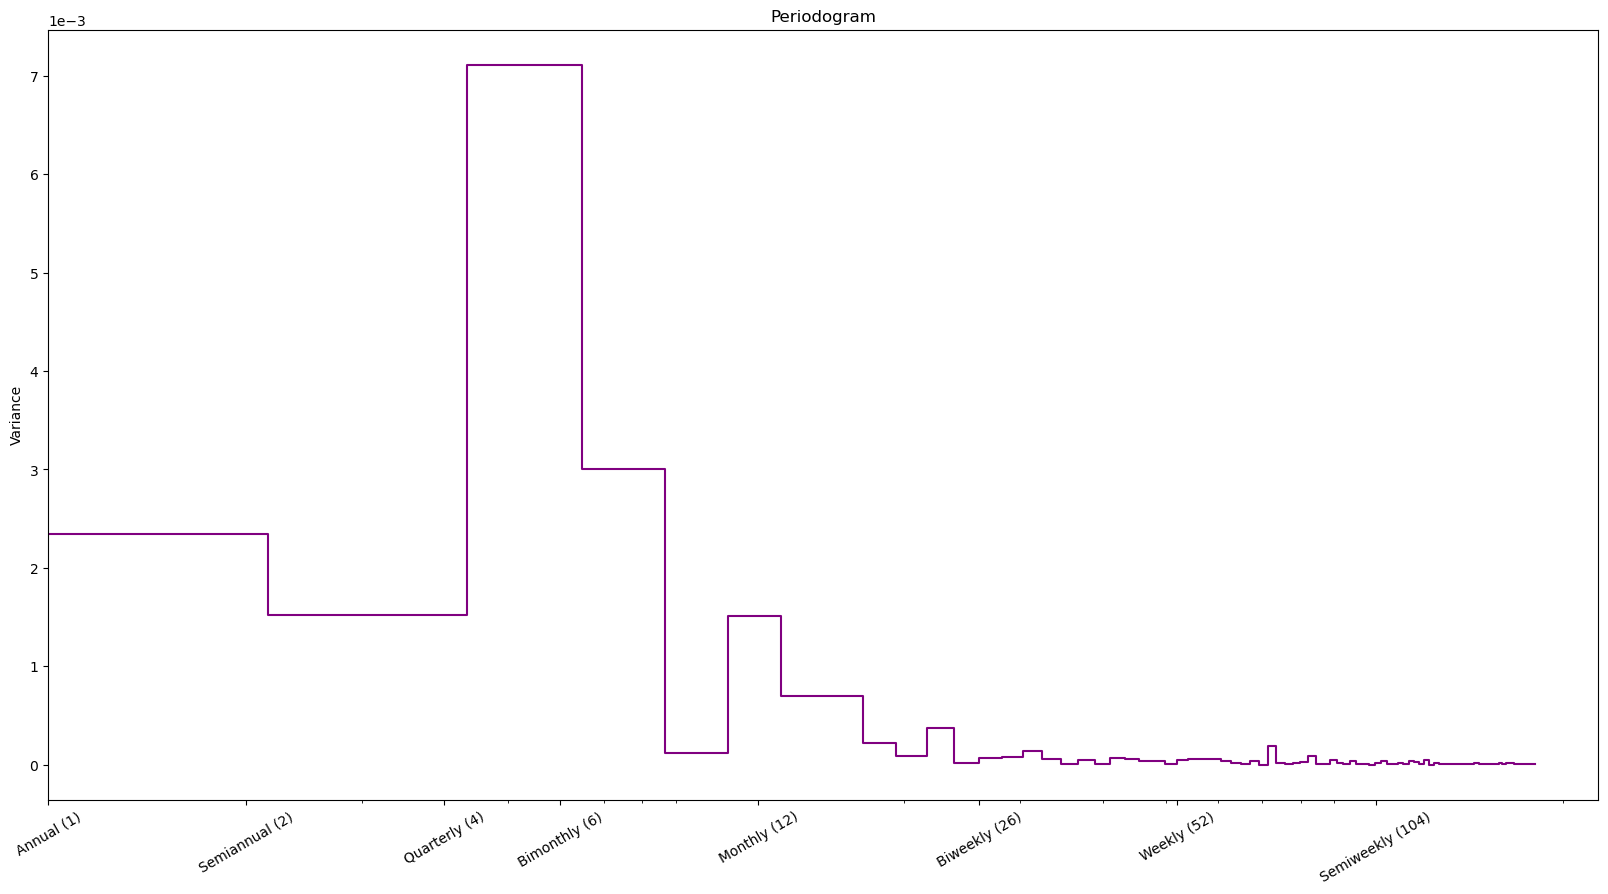

In [44]:
# Periodogram configuration as found on the Kaggle time series course
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.signal import periodogram

fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
freqencies, spectrum = periodogram(
    pr_detrended,
    fs=fs,
    detrend='linear',
    window="boxcar",
    scaling='spectrum',
)

_, ax = plt.subplots()
ax.step(freqencies, spectrum, color="purple")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=30,
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")

In [13]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='A', order=24)
dp = DeterministicProcess(
    index=pd.DatetimeIndex(pr_detrended.index.values),
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
dp.in_sample()

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)",...,"sin(20,freq=A-DEC)","cos(20,freq=A-DEC)","sin(21,freq=A-DEC)","cos(21,freq=A-DEC)","sin(22,freq=A-DEC)","cos(22,freq=A-DEC)","sin(23,freq=A-DEC)","cos(23,freq=A-DEC)","sin(24,freq=A-DEC)","cos(24,freq=A-DEC)"
2015-01-04,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.858764,0.512371,0.884068,0.467359,0.907014,0.421101,0.927542,0.373720,0.945596,0.325342
2015-01-11,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.296713,-0.954967,-0.455907,-0.890028,-0.601624,-0.798779,-0.729558,-0.683919,-0.835925,-0.548843
2015-01-18,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.417194,0.908818,-0.137279,0.990532,0.154309,0.988023,0.432776,0.901502,0.674444,0.738326
2015-01-25,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.917584,-0.397543,0.680773,-0.732494,0.329408,-0.944188,-0.077386,-0.997001,-0.471160,-0.882048
2015-02-01,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.948362,-0.317191,-0.977848,0.209315,-0.735417,0.677615,-0.288482,0.957485,0.238673,0.971100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-25,1.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.085965,0.996298,0.858764,0.512371,0.917584,-0.397543,0.213521,-0.976938,-0.668064,-0.744104
2018-03-04,1.0,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.601624,-0.798779,-0.409356,-0.912375,-0.996659,-0.081676,-0.552435,0.833556,0.463550,0.886071
2018-03-11,1.0,167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.981306,0.192452,-0.188227,0.982126,0.840618,0.541628,0.816538,-0.577292,-0.230306,-0.973118
2018-03-18,1.0,168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.858764,0.512371,0.717677,-0.696376,-0.486273,-0.873807,-0.970064,0.242850,-0.017213,0.999852


In [14]:
priceReg_season = LinearRegression().fit(dp.in_sample(), pr_detrended)

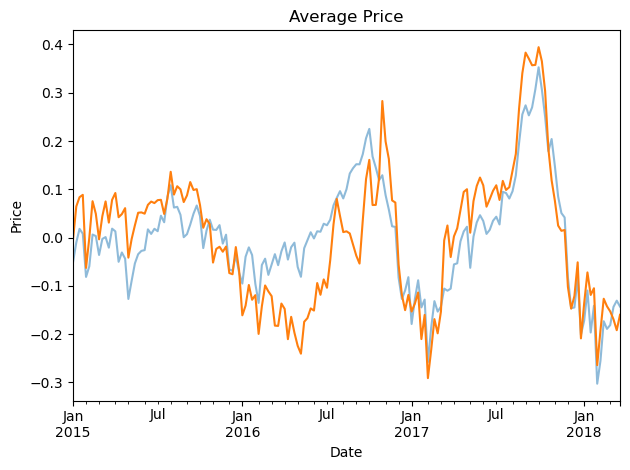

In [15]:
from matplotlib import pyplot as plt

p = pd.Series(priceReg_season.predict(dp.in_sample()), index=cleaned.index).plot(alpha=0.5, title="Average Price", ylabel="Price")
p = pr_detrended.plot()
p.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.show()

In [16]:
pr_residual = pr_detrended - priceReg_season.predict(dp.in_sample())

<AxesSubplot:xlabel='Date'>

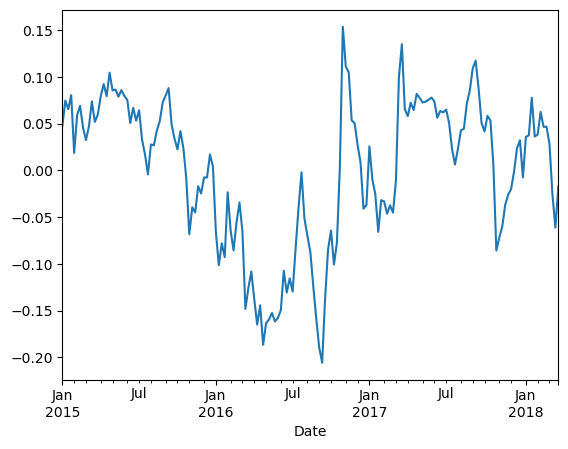

In [17]:
pr_residual.plot()

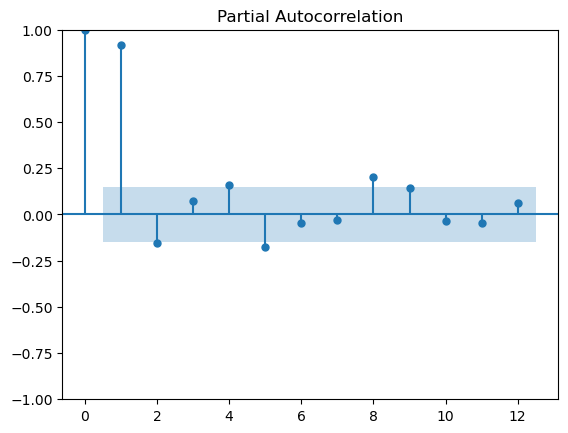

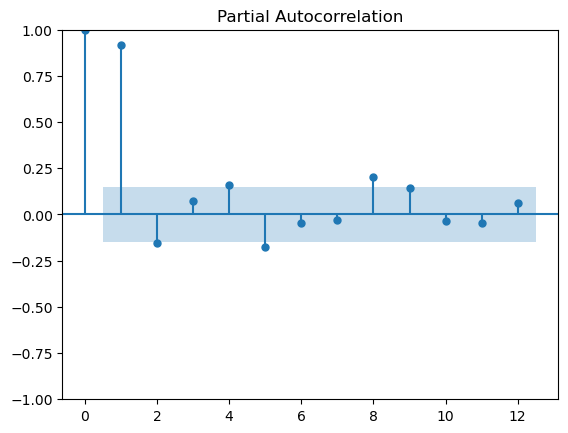

In [18]:
# Choose lag steps
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(pr_residual, lags=12, method='ywm')

In [19]:
lags_pr = pd.DataFrame(index=cleaned.index)

lags_pr["pr_residual_1"] = pr_residual.shift(1)
lags_pr["pr_residual_2"] = pr_residual.shift(2)
lags_pr["pr_residual_4"] = pr_residual.shift(4)
lags_pr["pr_residual_5"] = pr_residual.shift(5)
lags_pr["pr_residual_8"] = pr_residual.shift(8)

In [20]:
lags_pr.head()

,pr_residual_1,pr_residual_2,pr_residual_4,pr_residual_5,pr_residual_8
Date,,,,,
2015-01-04,NaN,NaN,NaN,NaN,NaN
2015-01-11,0.047344,NaN,NaN,NaN,NaN
2015-01-18,0.074771,0.047344,NaN,NaN,NaN
2015-01-25,0.065614,0.074771,NaN,NaN,NaN
2015-02-01,0.080537,0.065614,0.047344,NaN,NaN


In [21]:
lags_pr.tail()

,pr_residual_1,pr_residual_2,pr_residual_4,pr_residual_5,pr_residual_8
Date,,,,,
2018-02-25,0.046645,0.062677,0.036289,0.077798,-0.007409
2018-03-04,0.046788,0.046645,0.038412,0.036289,0.035957
2018-03-11,0.028221,0.046788,0.062677,0.038412,0.037537
2018-03-18,-0.025693,0.028221,0.046645,0.062677,0.077798
2018-03-25,-0.061184,-0.025693,0.046788,0.046645,0.036289


In [22]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

prePipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    #('std_scaler', StandardScaler())
])

mlPrepared_pr = pd.DataFrame(prePipeline.fit_transform(lags_pr), index=lags_pr.index)

In [23]:
targetSteps_pr = pd.DataFrame(pr_residual)
step_length = 10
for i in range(1, step_length + 1, 1):
    targetSteps_pr["pr_residual_" + str(i)] = pr_residual.shift(-(i)).fillna(pr_residual.median())
targetSteps_pr.head()

,AveragePrice,pr_residual_1,pr_residual_2,pr_residual_3,pr_residual_4,pr_residual_5,pr_residual_6,pr_residual_7,pr_residual_8,pr_residual_9,pr_residual_10
Date,,,,,,,,,,,
2015-01-04,0.047344,0.074771,0.065614,0.080537,0.018788,0.058941,0.069140,0.046098,0.032494,0.047117,0.073859
2015-01-11,0.074771,0.065614,0.080537,0.018788,0.058941,0.069140,0.046098,0.032494,0.047117,0.073859,0.051952
2015-01-18,0.065614,0.080537,0.018788,0.058941,0.069140,0.046098,0.032494,0.047117,0.073859,0.051952,0.059696
2015-01-25,0.080537,0.018788,0.058941,0.069140,0.046098,0.032494,0.047117,0.073859,0.051952,0.059696,0.079471
2015-02-01,0.018788,0.058941,0.069140,0.046098,0.032494,0.047117,0.073859,0.051952,0.059696,0.079471,0.092380


In [24]:
mlPrepared_pr

,0,1,2,3,4
Date,,,,,
2015-01-04,0.023783,0.023789,0.023789,0.023783,0.023513
2015-01-11,0.047344,0.023789,0.023789,0.023783,0.023513
2015-01-18,0.074771,0.047344,0.023789,0.023783,0.023513
2015-01-25,0.065614,0.074771,0.023789,0.023783,0.023513
2015-02-01,0.080537,0.065614,0.047344,0.023783,0.023513
...,...,...,...,...,...
2018-02-25,0.046645,0.062677,0.036289,0.077798,-0.007409
2018-03-04,0.046788,0.046645,0.038412,0.036289,0.035957
2018-03-11,0.028221,0.046788,0.062677,0.038412,0.037537


In [25]:
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor

priceMod_residual = RegressorChain(base_estimator=XGBRegressor())
demandMod_residual = RegressorChain(base_estimator=XGBRegressor())
elasticityMod_residual = RegressorChain(base_estimator=XGBRegressor())

priceMod_residual.fit(mlPrepared_pr, targetSteps_pr)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, ran

In [26]:
priceMod_residual.predict(mlPrepared_pr)

array([[ 0.04243369,  0.06349062,  0.06550266, ..., -0.02108767,
         0.01651099,  0.00790936],
       [ 0.07449332,  0.06617909,  0.07860241, ...,  0.04324548,
         0.06269611,  0.04496841],
       [ 0.06588607,  0.07970929,  0.02999174, ...,  0.02712782,
         0.02036152,  0.02941649],
       ...,
       [-0.02293414, -0.06057703, -0.01737472, ...,  0.01747918,
         0.00336668, -0.01335926],
       [-0.06199757, -0.01703277,  0.02342279, ...,  0.05121116,
         0.05729502,  0.05418853],
       [-0.01637549,  0.01536541,  0.01123908, ..., -0.0327343 ,
        -0.03225047, -0.02005872]])

In [27]:
# Forecast according to mean date period due to potentiallly uneven difference
foreDate = (np.arange(100, dtype=int) + 1) * int(date.diff().mean()) + date.iloc[-1]
foreData = pd.DataFrame((datetime.fromordinal(i) for i in foreDate), columns=["Date"])

In [28]:
foreData

,Date
0,2018-04-01
1,2018-04-08
2,2018-04-15
3,2018-04-22
4,2018-04-29
...,...
95,2020-01-26
96,2020-02-02
97,2020-02-09
98,2020-02-16


In [29]:
mlPrepared_pr

,0,1,2,3,4
Date,,,,,
2015-01-04,0.023783,0.023789,0.023789,0.023783,0.023513
2015-01-11,0.047344,0.023789,0.023789,0.023783,0.023513
2015-01-18,0.074771,0.047344,0.023789,0.023783,0.023513
2015-01-25,0.065614,0.074771,0.023789,0.023783,0.023513
2015-02-01,0.080537,0.065614,0.047344,0.023783,0.023513
...,...,...,...,...,...
2018-02-25,0.046645,0.062677,0.036289,0.077798,-0.007409
2018-03-04,0.046788,0.046645,0.038412,0.036289,0.035957
2018-03-11,0.028221,0.046788,0.062677,0.038412,0.037537


In [30]:
# loop to generate forcast iteratively
foreRes_pr = pd.DataFrame(np.zeros((100, step_length + 1)), columns=list("PriceForecast_" + str(i) for i in range(0, step_length + 1, 1)), index=range(100))

foreRes_pr.iloc[0] = priceMod_residual.predict(mlPrepared_pr.iloc[[-1]])
for i in range(1, 100, 1):
    foreRes_pr.iloc[i] = priceMod_residual.predict(foreRes_pr.iloc[:, :5].iloc[[i - 1]])

c:\Users\ghy24\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  warnings.warn(
c:\Users\ghy24\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  warnings.warn(
c:\Users\ghy24\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  warnings.warn(
c:\Users\ghy24\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  warnings.warn(
c:\Users\ghy24\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  warnings.warn(
c:\Users\ghy24\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  warnings.warn

In [31]:
foreRes_pr

,PriceForecast_0,PriceForecast_1,PriceForecast_2,PriceForecast_3,PriceForecast_4,PriceForecast_5,PriceForecast_6,PriceForecast_7,PriceForecast_8,PriceForecast_9,PriceForecast_10
0,-0.016375,0.015365,0.011239,-0.028218,-0.029979,-0.039313,-0.030955,-0.050257,-0.032734,-0.032250,-0.020059
1,-0.039446,-0.024245,-0.044168,-0.005151,0.004145,-0.027020,-0.047629,-0.043693,-0.045146,-0.064175,-0.092007
2,-0.019895,-0.005194,0.017141,0.011632,-0.020493,-0.016432,-0.042562,-0.042035,-0.050494,-0.056603,-0.047514
3,-0.048567,-0.041745,-0.040031,-0.030250,-0.024995,-0.057463,-0.063002,-0.085965,-0.078905,-0.092600,-0.069743
4,0.049647,0.101209,0.103743,0.064874,0.068165,0.070043,0.076416,0.068207,0.061518,0.075571,0.076208
...,...,...,...,...,...,...,...,...,...,...,...
95,-0.018892,-0.019746,0.021590,0.046705,0.054627,0.047507,0.020182,0.018065,-0.006512,-0.019036,-0.009941
96,-0.017265,0.023143,0.013664,0.010979,0.006326,0.006648,-0.014936,0.005672,0.002531,-0.003804,-0.010497
97,-0.052354,-0.037918,-0.039420,-0.045402,-0.025257,-0.028906,-0.061260,-0.051198,-0.045722,-0.062359,-0.068062
98,0.026237,0.025909,0.009811,-0.025693,-0.054614,-0.043322,-0.076226,-0.080449,-0.074437,-0.080531,-0.058109


In [32]:
for i in range(0, step_length + 1):
    foreRes_pr["PriceForecast_" + str(i)] += priceReg_trend.predict(foreData["Date"].apply(lambda x: x.toordinal()).values.reshape(-1, 1)) + priceReg_season.predict(dp.out_of_sample(100, foreData["Date"]))

In [33]:
foreData.set_index("Date")

""
Date
2018-04-01
2018-04-08
2018-04-15
2018-04-22
2018-04-29
...
2020-01-26
2020-02-02
2020-02-09


In [34]:
foreRes_pr.set_index(foreData["Date"])

,PriceForecast_0,PriceForecast_1,PriceForecast_2,PriceForecast_3,PriceForecast_4,PriceForecast_5,PriceForecast_6,PriceForecast_7,PriceForecast_8,PriceForecast_9,PriceForecast_10
Date,,,,,,,,,,,
2018-04-01,1.412409,1.444150,1.440024,1.400567,1.398806,1.389472,1.397830,1.378528,1.396051,1.396534,1.408726
2018-04-08,1.413629,1.428830,1.408907,1.447924,1.457221,1.426055,1.405446,1.409382,1.407929,1.388900,1.361068
2018-04-15,1.496743,1.511445,1.533779,1.528270,1.496146,1.500207,1.474077,1.474603,1.466144,1.460036,1.469125
2018-04-22,1.489959,1.496781,1.498495,1.508276,1.513532,1.481063,1.475524,1.452561,1.459621,1.445926,1.468784
2018-04-29,1.638615,1.690177,1.692711,1.653842,1.657133,1.659011,1.665384,1.657175,1.650487,1.664540,1.665176
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,1.415283,1.414428,1.455764,1.480879,1.488802,1.481682,1.454356,1.452240,1.427662,1.415139,1.424234
2020-02-02,1.239538,1.279947,1.270467,1.267782,1.263129,1.263451,1.241867,1.262476,1.259334,1.252999,1.246306
2020-02-09,1.163770,1.178206,1.176704,1.170722,1.190868,1.187218,1.154864,1.164926,1.170402,1.153765,1.148062


In [35]:
foreData = foreData.join(foreRes_pr)

In [36]:
foreData.head()

,Date,PriceForecast_0,PriceForecast_1,PriceForecast_2,PriceForecast_3,PriceForecast_4,PriceForecast_5,PriceForecast_6,PriceForecast_7,PriceForecast_8,PriceForecast_9,PriceForecast_10
0,2018-04-01,1.412409,1.444150,1.440024,1.400567,1.398806,1.389472,1.397830,1.378528,1.396051,1.396534,1.408726
1,2018-04-08,1.413629,1.428830,1.408907,1.447924,1.457221,1.426055,1.405446,1.409382,1.407929,1.388900,1.361068
2,2018-04-15,1.496743,1.511445,1.533779,1.528270,1.496146,1.500207,1.474077,1.474603,1.466144,1.460036,1.469125
3,2018-04-22,1.489959,1.496781,1.498495,1.508276,1.513532,1.481063,1.475524,1.452561,1.459621,1.445926,1.468784
4,2018-04-29,1.638615,1.690177,1.692711,1.653842,1.657133,1.659011,1.665384,1.657175,1.650487,1.664540,1.665176


In [37]:
cleaned[["AveragePrice"]]

,AveragePrice
Date,
2015-01-04,1.301296
2015-01-11,1.370648
2015-01-18,1.391111
2015-01-25,1.397130
2015-02-01,1.247037
...,...
2018-02-25,1.359630
2018-03-04,1.350185
2018-03-11,1.335093


<AxesSubplot:xlabel='Date'>

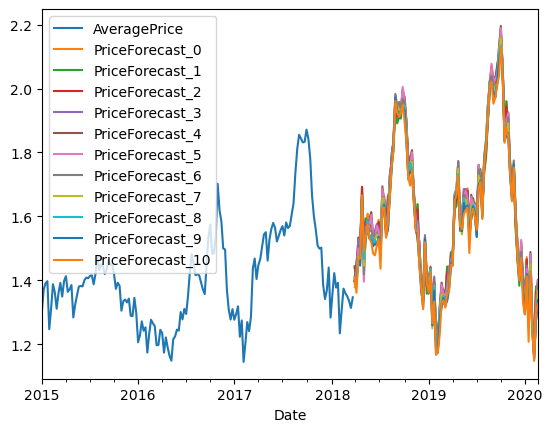

In [38]:
pd.concat([cleaned[["AveragePrice"]], foreData.set_index("Date")]).plot()

In [39]:
foreData.set_index("Date", inplace=True)

<AxesSubplot:xlabel='Date'>

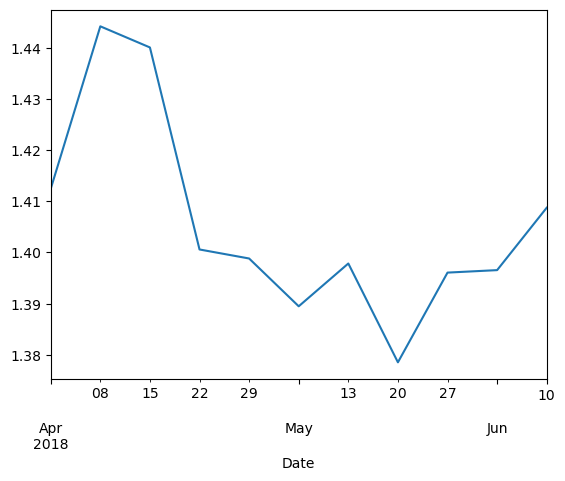

In [40]:
pd.Series(foreData.iloc[0].values,index=foreData.index[0 : 0 + step_length + 1]).plot()

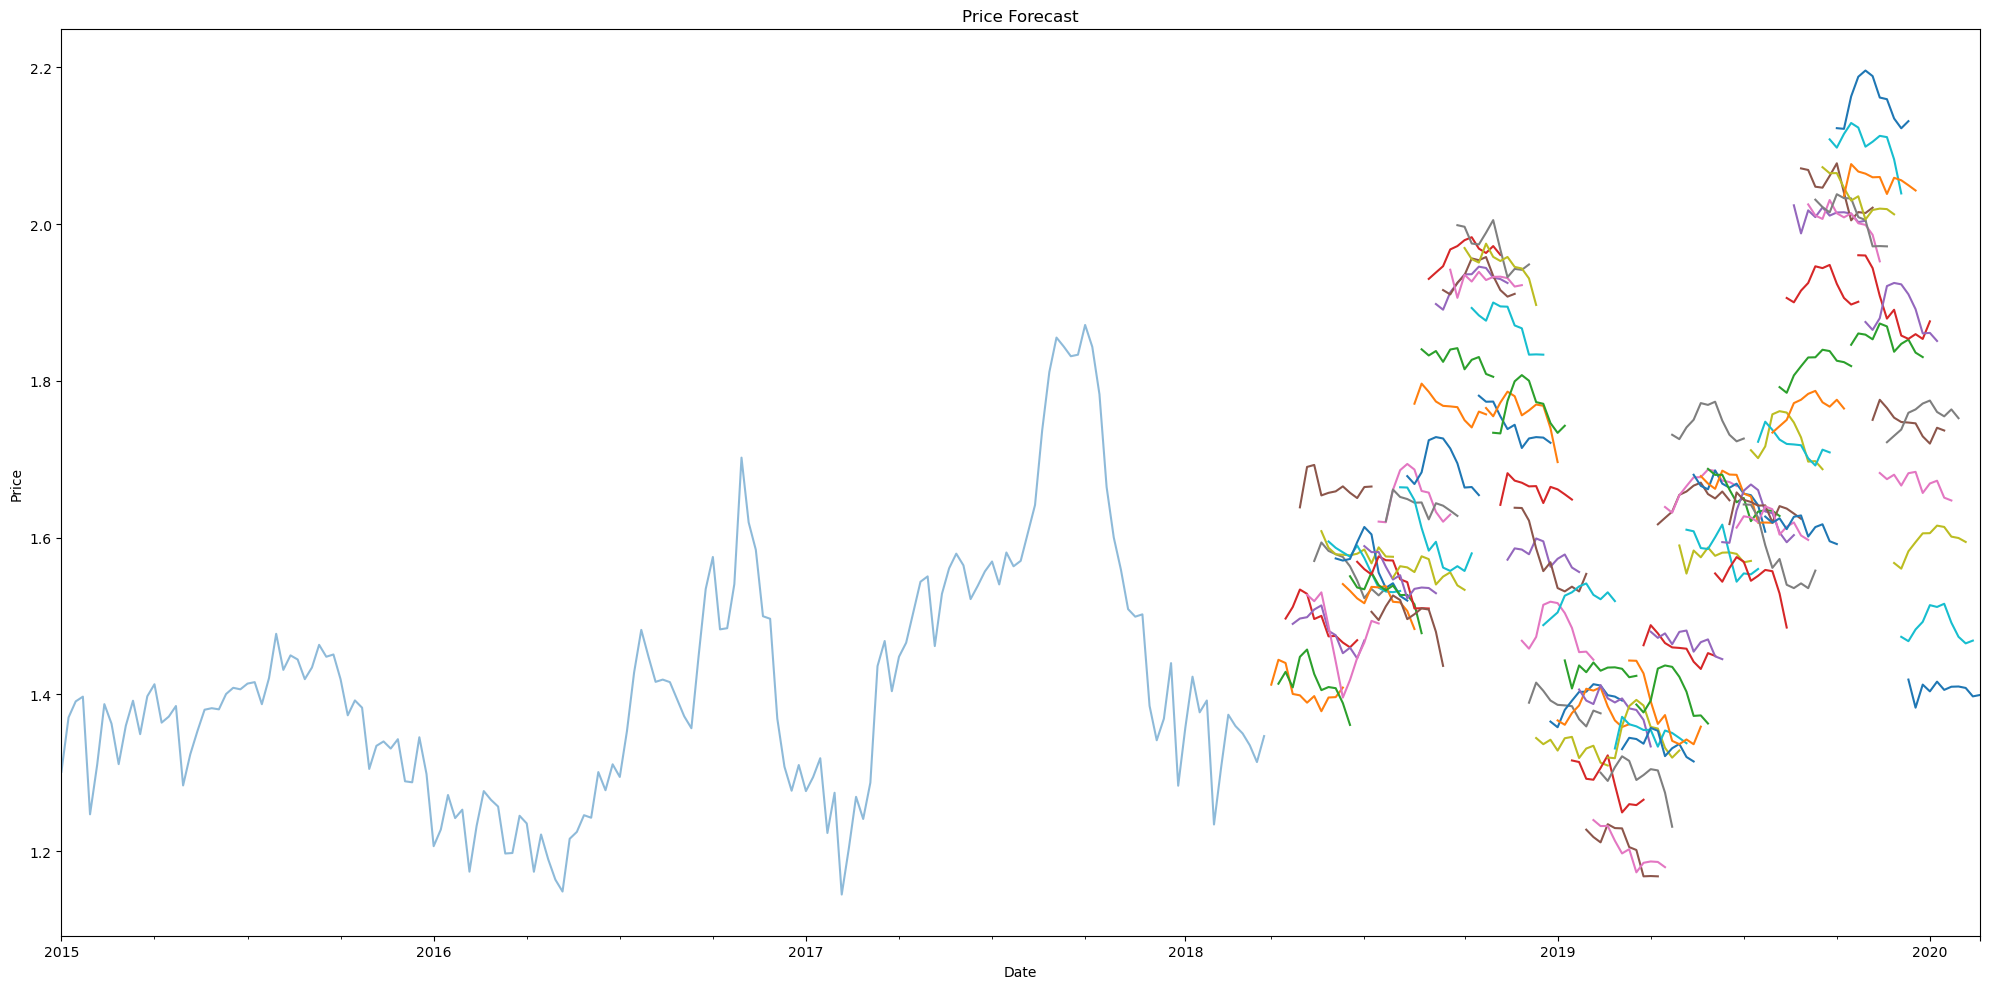

In [42]:
totalIndex = pd.concat([cleaned[["AveragePrice"]], foreData]).index
p = cleaned["AveragePrice"].plot(alpha=0.5, title="Price Forecast", ylabel="Price", xticks=totalIndex)
for i in range(0, 90):
    pred = foreData.iloc[i]
    pred.index=foreData.index[i : i + step_length + 1]
    p = pred.plot()
#p = foreData["PriceForecast_0"].plot()
p.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()